<h1>Data Import and Path Setup</h2>

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from openTSNE import TSNE
import umap

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import hdbscan
from sklearn import mixture

from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics.cluster import normalized_mutual_info_score

from time import time
import seaborn as sns


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuration
umap_seed = 143
tsne_seed = 42
max_jobs = -1    # If the RAM gets used up in your case, modify it to reduce RAM usage
num_comp = 2
num_clusters = 2

# Dataset extraction and analysis
path_expression = '../data/TCGA.BRCA.expression.txt'
path_metadata = '../data/TCGA.BRCA.metadata.txt'
path_mutation = '../data/TCGA.BRCA.mutations.txt'
path_sup = "../data/Supplementary Tables 1-4.csv"

df_exp = pd.read_csv(path_expression, delimiter='\t')  # \s+ handles multiple spaces
df_meta = pd.read_csv(path_metadata, delimiter='\t')
df_mut = pd.read_csv(path_mutation, delimiter=r'\t')
df_sup = pd.read_csv(path_sup, delimiter=',')
df_exp.head()


/tmp/ipykernel_7435/606298354.py:16: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_mut = pd.read_csv(path_mutation, delimiter=r'\t')


,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,0.0000,16.3644,12.9316,52.1503,408.076,0.0,1187.010,0.0000,...,415.824,931.957,129.5920,1007.780,1658.500,258.4940,1208.370,3507.25,1894.930,1180.460
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.0000,9.2659,17.3790,69.7553,563.893,0.0,516.041,1.0875,...,1161.330,965.198,59.8151,448.613,1343.120,198.4770,603.589,5504.62,1318.650,406.743
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.9066,11.6228,9.2294,154.2970,1360.830,0.0,592.022,0.0000,...,305.422,2531.280,35.3581,533.998,768.812,331.8220,532.185,5458.75,942.883,509.519
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.0000,12.0894,11.0799,143.8640,865.536,0.0,552.751,0.4137,...,394.506,668.597,55.0269,437.733,863.881,175.4240,607.365,5691.35,781.134,700.869
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.0000,6.8468,14.4298,84.2128,766.383,0.0,260.851,0.4255,...,405.711,674.468,48.9362,424.255,1049.790,14.0426,775.745,4041.70,831.915,881.702


In [3]:
df_meta.head()


,patient_id,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
0,TCGA-3C-AAAU,BRCA,55.0,FEMALE,WHITE,Stage X,Infiltrating Lobular Carcinoma,[Not Available],WITH TUMOR,Alive,0.0,4047.0,0.0,4047.0,1.0,1808.0,1.0,1808.0,NaN
1,TCGA-3C-AALI,BRCA,50.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,4005.0,0.0,4005.0,0.0,4005.0,0.0,4005.0,NaN
2,TCGA-3C-AALJ,BRCA,62.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IIB,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1474.0,0.0,1474.0,0.0,1474.0,0.0,1474.0,NaN
3,TCGA-3C-AALK,BRCA,52.0,FEMALE,BLACK OR AFRICAN AMERICAN,Stage IA,Infiltrating Ductal Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,1448.0,0.0,1448.0,NaN,NaN,0.0,1448.0,NaN
4,TCGA-4H-AAAK,BRCA,50.0,FEMALE,WHITE,Stage IIIA,Infiltrating Lobular Carcinoma,[Not Available],TUMOR FREE,Alive,0.0,348.0,0.0,348.0,0.0,348.0,0.0,348.0,NaN


In [4]:
df_mut.head()


,patient_id,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Variant_Classification,...,SIFT,PolyPhen,DOMAINS,IMPACT,VARIANT_CLASS,FILTER,COSMIC,CALLERS,CONTEXT,NCALLERS
0,TCGA-3C-AAAU,WDR11,0,.,GRCh37,10,122668955,122668955,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,SOMATICSNIPER|RADIA|MUTECT|MUSE|VARSCANS,TATGAGATGTA,5
1,TCGA-3C-AAAU,GATA3,0,.,GRCh37,10,8115874,8115875,+,Frame_Shift_Ins,...,.,.,"Low_complexity_(Seg):seg,hmmpanther:PTHR10071:...",HIGH,insertion,PASS,NONE,INDELOCATOR*|VARSCANI*|PINDEL,CATCTCGCCCT,3
2,TCGA-3C-AAAU,MALAT1,0,.,GRCh37,11,65272906,65272908,+,RNA,...,.,.,.,MODIFIER,deletion,PASS,NONE,VARSCANI*|PINDEL,AATAATAAAGCCCA,2
3,TCGA-3C-AAAU,CD248,0,.,GRCh37,11,66082467,66082467,+,Missense_Mutation,...,tolerated(0.12),benign(0.001),"Low_complexity_(Seg):seg,hmmpanther:PTHR24838:...",MODERATE,SNV,PASS,NONE,MUTECT|VARSCANS,GTGCTCGGCAA,2
4,TCGA-3C-AAAU,NPAS4,0,.,GRCh37,11,66193652,66193652,+,3'UTR,...,.,.,.,MODIFIER,SNV,PASS,NONE,RADIA|MUTECT|MUSE|VARSCANS,ATCAAGAGACT,4


In [5]:
df_sup.head()

,Complete TCGA ID,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
0,TCGA-A2-A0T2,FEMALE,66.0,Negative,Negative,Negative,T3,T_Other,N3,Positive,...,Basal-like,0.0,-13.0,3.0,5.0,Basal,3.0,2.0,2.0,2.0
1,TCGA-A2-A04P,FEMALE,36.0,Negative,Negative,Negative,T2,T_Other,N3,Positive,...,Basal-like,0.0,-13.0,5.0,5.0,Basal,1.0,2.0,2.0,2.0
2,TCGA-A1-A0SK,FEMALE,54.0,Negative,Negative,Negative,T2,T_Other,N0,Negative,...,Basal-like,-6.0,-13.0,5.0,5.0,Basal,1.0,2.0,2.0,2.0
3,TCGA-A2-A0CM,FEMALE,40.0,Negative,Negative,Negative,T2,T_Other,N0,Negative,...,Basal-like,-12.0,-13.0,4.0,4.0,Basal,4.0,2.0,1.0,1.0
4,TCGA-AR-A1AR,FEMALE,50.0,Negative,Negative,Negative,T1,T1,N2,Positive,...,Basal-like,0.0,-13.0,5.0,5.0,NaN,1.0,NaN,NaN,NaN


In [6]:
df_exp.patient_id.isin(df_sup['Complete TCGA ID']).sum()

np.int64(917)

<h1>Data Preprocessing</h1>

<h2>Log2(X+1) Transform</h2>

In [7]:
df_logexp = pd.concat([df_exp.iloc[:,:2], np.log2(df_exp.iloc[:,2:]+1)], axis=1)
df_logexp.head()

,patient_id,sample_id,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,0.000000,4.118061,3.800289,5.732006,8.676225,0.0,10.214331,0.000000,...,8.703295,9.865667,7.028923,9.978396,10.696533,8.019557,10.240040,11.776536,10.888690,10.206355
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.000000,3.359788,4.199986,6.144766,9.141834,0.0,9.014135,1.061776,...,10.182804,9.916175,5.926358,8.812540,10.392446,7.640079,9.239811,12.426689,10.365940,8.671516
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.931002,3.657960,3.354650,7.278886,10.411331,0.0,9.211942,0.000000,...,8.259376,11.306221,5.184205,9.063390,9.588362,8.378607,9.058492,12.414619,9.882464,8.995821
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.000000,3.710327,3.594537,7.178555,9.759116,0.0,9.113094,0.499476,...,8.627556,9.387149,5.808048,8.777199,9.756358,7.462903,9.248793,12.474809,9.611272,9.455058
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.000000,2.972104,3.947647,6.412998,9.583803,0.0,8.032602,0.511468,...,8.667860,9.399744,5.642014,8.732184,10.037259,3.910982,9.601297,11.981103,9.702025,9.785783


<h2>Remove lowly expressed and low variance genes</h2>

In [88]:
MEAN_THRESH = 1.5
PCA_VAR_QUANTILE = 0.1
UMAP_VAR_QUANTILE = 0.99

keep_count = (df_logexp.iloc[:,2:].mean(axis=0) >= MEAN_THRESH).sum()
print(f'Will use a mean threshold of {MEAN_THRESH} to keep {keep_count} genes')

# remove low expressed genes with mean < 1 or median == 0
df_logexp_filtered = df_logexp.iloc[:,2:].loc[:, df_logexp.iloc[:, 2:].mean(axis=0) >= MEAN_THRESH]
print(f'Will retain genes with median>0 to keep {(df_logexp_filtered.median(axis=0) > 0).sum()} genes')
df_logexp_filtered = df_logexp_filtered.loc[:, df_logexp_filtered.median(axis=0) > 0]
df_logexp_filtered = pd.concat([df_logexp.iloc[:,:2], df_logexp_filtered], axis=1)

# keep some percentile of genes with high variance. For PCA just remove bottom 10%
gene_variance = df_logexp_filtered.iloc[:,2:].var(axis=0)
pca_var_thresh = gene_variance.quantile(PCA_VAR_QUANTILE)
umap_var_thresh = gene_variance.quantile(UMAP_VAR_QUANTILE)
pca_genes = gene_variance[gene_variance >= pca_var_thresh].index
umap_genes = gene_variance[gene_variance >= umap_var_thresh].index

Will use a mean threshold of 1.5 to keep 16557 genes
Will retain genes with median>0 to keep 16556 genes


<h2>Create base df for pca and umap</h2>

In [89]:
df_pca = pd.concat([df_logexp_filtered.iloc[:,:2], df_logexp_filtered[pca_genes]], axis=1)
df_umap = pd.concat([df_logexp_filtered.iloc[:,:2], df_logexp_filtered[umap_genes]], axis=1)


<h2>Get PAM50 labels</h2>

In [26]:
# get intersect of people in study
overlap = df_sup[df_logexp_filtered.patient_id.isin(df_sup['Complete TCGA ID'])]
# need to reorder the rows to match order of df_logexp_filtered
overlap = overlap.set_index('Complete TCGA ID').reindex(df_logexp_filtered['patient_id']).reset_index()
pam50_labels = overlap['PAM50 mRNA']

/tmp/ipykernel_7435/2055710615.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  overlap = df_sup[df_logexp_filtered.patient_id.isin(df_sup['Complete TCGA ID'])]


<h1>Dimensionality Reduce</h1>

In [82]:
def umap_reduce(data_no_label,n_comp = num_comp, measure='euclidean', r_seed = umap_seed, m_job = max_jobs, grad = 'bh'):
  t0 = time()
  reducer = umap.UMAP(n_components = n_comp, metric=measure, random_state=r_seed, n_jobs=m_job)
  embedding_umap = reducer.fit_transform(data_no_label)
  t1 = time()
  print('UMAP running time is: ' + str(t1-t0) + ' s' )

  return embedding_umap

def tsne_reduce(data_no_label,n_comp = num_comp, r_seed = tsne_seed, m_job = max_jobs):
  t0 = time()
  embedding_tsne = TSNE(n_components=n_comp, random_state= r_seed, n_jobs=m_job, negative_gradient_method='bh').fit(data_no_label)
  t1 = time()
  print('t-SNE running time is: ' + str(t1-t0) + ' s' )

  return embedding_tsne

def mds_reduce(data_no_label,n_comp = num_comp,m_job = max_jobs):
  t0 = time()
  embedding_mds = MDS(n_components=n_comp, n_jobs=m_job).fit_transform(data_no_label)
  t1 = time()
  print('MDS running time is: ' + str(t1-t0) + ' s' )

  return embedding_mds

def pca_reduce(data_no_label,n_comp = num_comp):
  t0 = time()
  scaler = StandardScaler()
  data_scale = scaler.fit_transform(data_no_label)
  pca = PCA(n_components = n_comp)
  embedding_pca = pca.fit_transform(data_scale)
  t1 = time()
  print('PCA running time is: ' + str(t1-t0) + ' s' )

  return embedding_pca

from sklearn.preprocessing import LabelEncoder

def plot_embedding(embedding, label=pam50_labels, title='UMAP'):
    # Encode labels to integers
    label_encoder = LabelEncoder()
    label_encoded = label_encoder.fit_transform(label)

    # Plot
    fig, ax = plt.subplots()
    palette = sns.color_palette(n_colors=len(np.unique(label_encoded)))
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], c=[palette[i] for i in label_encoded])
    ax.set_title(title)
    plt.axis('off')
    plt.show()


In [68]:
embedding_umap = umap_reduce(df_pca_scaled.iloc[:,2:])
#embedding_tsne = tsne_reduce(df_pca_scaled.iloc[:,2:])
embedding_mds = mds_reduce(df_pca_scaled.iloc[:,2:])
embedding_pca = pca_reduce(df_pca_scaled.iloc[:,2:])

/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 9.622315406799316 s
MDS running time is: 24.816951036453247 s
PCA running time is: 1.1525650024414062 s


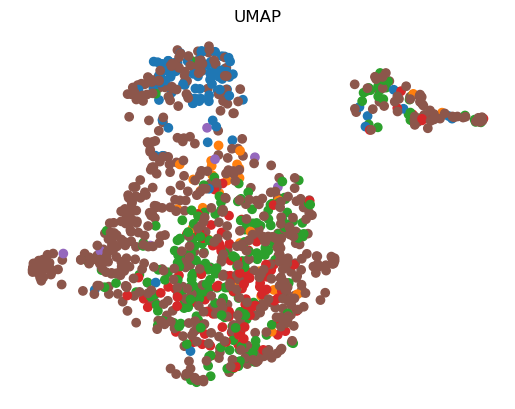

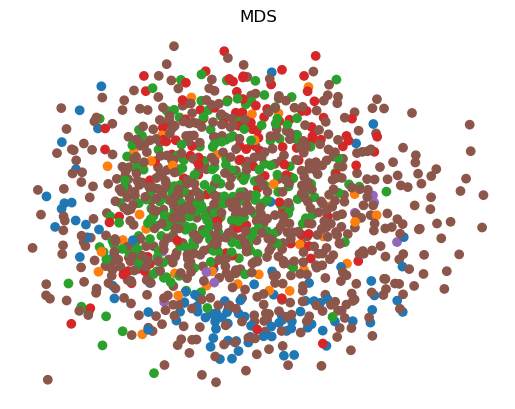

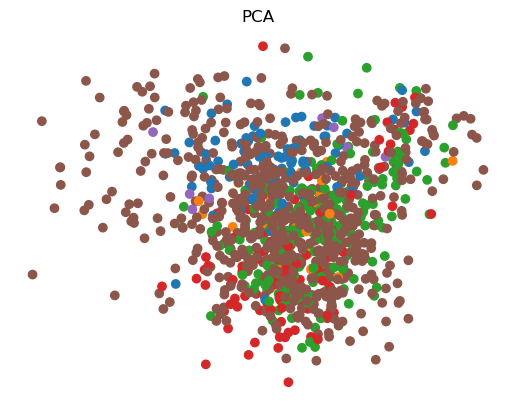

In [76]:
plot_embedding(embedding_umap, title='UMAP')
#plot_embedding(embedding_tsne, title='t-SNE')
plot_embedding(embedding_mds, title='MDS')
plot_embedding(embedding_pca, title='PCA')

In [77]:
# K-means
km = KMeans(n_clusters = num_clusters, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
kmeans_umap = km.fit_predict(embedding_umap)
#kmeans_tsne = km.fit_predict(embedding_tsne)
kmeans_mds = km.fit_predict(embedding_mds)
kmeans_pca = km.fit_predict(embedding_pca)

# Hierarchical clustering:  AgglomerativeClustering
clusterer_hierarchical = AgglomerativeClustering(n_clusters = num_clusters )
hc_umap = clusterer_hierarchical.fit_predict(embedding_umap)
#hc_tsne = clusterer_hierarchical.fit_predict(embedding_tsne)
hc_mds = clusterer_hierarchical.fit_predict(embedding_mds)
hc_pca = clusterer_hierarchical.fit_predict(embedding_pca)

# SpectralClustering
spectral_Clustering = SpectralClustering(n_clusters = num_clusters, assign_labels="discretize", random_state=0)
spc_umap = spectral_Clustering.fit_predict(embedding_umap)
#spc_tsne = spectral_Clustering.fit_predict(embedding_tsne)
spc_mds = spectral_Clustering.fit_predict(embedding_mds)
spc_pca = spectral_Clustering.fit_predict(embedding_pca)

# Gaussian mixture model
gmm = mixture.GaussianMixture(n_components = num_clusters, covariance_type='full')
gmm_umap = gmm.fit_predict(embedding_umap)
#gmm_tsne = gmm.fit_predict(embedding_tsne)
gmm_mds = gmm.fit_predict(embedding_mds)
gmm_pca = gmm.fit_predict(embedding_pca)


# HDBSCAN
clusterer_hdbscan = hdbscan.HDBSCAN(min_cluster_size = 10, gen_min_span_tree=True)
hdbscan_umap = clusterer_hdbscan.fit_predict(embedding_umap)
#hdbscan_tsne = clusterer_hdbscan.fit_predict(embedding_tsne)
hdbscan_mds = clusterer_hdbscan.fit_predict(embedding_mds)
hdbscan_pca = clusterer_hdbscan.fit_predict(embedding_pca)

#clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis', edge_alpha=0.6, node_size=80, edge_linewidth=2)
#clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)
#clusterer.condensed_tree_.plot()

# cluster_result = [kmeans_umap,kmeans_tsne,kmeans_mds,kmeans_pca,
#                   hc_umap,hc_tsne,hc_mds,hc_pca,
#                   spc_umap,spc_tsne,spc_mds,spc_pca,
#                   gmm_umap,gmm_tsne,gmm_mds,gmm_pca,
#                   hdbscan_umap,hdbscan_tsne,hdbscan_mds,hdbscan_pca]


# file = open("clustering_accuracy_NMI.txt","a") #append mode
# file.write( 'clustering_accuracy_NMI.txt' + "\n")
# for _, cluster in enumerate(cluster_result):
#    nmi = normalized_mutual_info_score(label_group, cluster)
#    file.write(str(nmi) + "\n")
# file.close()

# file = open("clustering_accuracy_ARI.txt","a") #append mode
# file.write( 'clustering_accuracy_ARI.txt' + "\n")
# for _, cluster in enumerate(cluster_result):
#    ari = adjusted_rand_score(label_group, cluster)
#    file.write(str(ari) + "\n")
# file.close()

/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
Exception ignored in: <function ResourceTracker.__del__ at 0x7f8cea52b600>
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7fee71d83600>
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  Fi

KeyboardInterrupt: 

In [ ]:
def plot_cluster(embedding, title='Eucledian'):
  fig, ax = plt.subplots()
  clusterer_hierarchical = AgglomerativeClustering(n_clusters = 3)
  clustering = clusterer_hierarchical.fit(embedding[20:,])
  ax.scatter(embedding[20:, 0], embedding[20:, 1],
            c=[sns.color_palette(["#E41A1C", "#377EB8", "#4DAF4A"])[x] for x in clustering.labels_[:]])
  plt.axis('off')
  ax.set_title(title)
  plt.show()

metric = ['euclidean','canberra','cosine']

embedding_umap = umap_reduce(data, measure = metric[0])
plot_cluster(embedding_umap, title=metric[0])

embedding_umap = umap_reduce(data, measure = metric[1])
plot_cluster(embedding_umap, title=metric[1])

embedding_umap = umap_reduce(data, measure = metric[2])
plot_cluster(embedding_umap, title=metric[2])

<h1>PCA/MDS Pipeline</h1>


<h2>PCA preprocessing</h2>

In [27]:
# z score genes
df_pca_scaled = pd.concat([df_pca.iloc[:,:2],df_pca.iloc[:,2:].apply(lambda x: (x - x.mean()) / x.std(), axis=0)], axis=1)
df_pca_scaled.head()

,patient_id,sample_id,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|390284,?|57714,?|645851,...,ZW10|9183,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,1.061971,1.071704,-1.684342,-2.403024,2.833416,-0.465077,0.314340,3.328970,...,-0.218103,0.016402,0.526776,1.583103,1.386598,1.209820,0.812786,-0.008733,1.125013,0.619145
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,0.429214,1.501906,-0.961651,-1.526434,1.599595,-1.879745,0.137286,3.508041,...,-0.844319,2.181617,0.568451,-0.036761,-0.311610,0.979129,-0.990598,0.933008,0.250662,-1.908679
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,0.678030,0.592053,1.024049,0.863617,1.802944,-1.147387,-0.574870,1.645934,...,-1.139374,-0.633258,1.715394,-1.127116,0.053782,1.428092,-1.317510,0.915524,-0.557998,-1.374561
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,0.721729,0.850249,0.848383,-0.364292,1.701326,-0.300631,-0.386956,0.644998,...,-1.058619,-0.094439,0.131946,-0.210580,-0.363088,0.871421,-0.974403,1.002708,-1.011594,-0.618214
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,0.105703,1.230309,-0.492011,-0.694349,0.590564,-1.005115,-0.409839,0.541172,...,-1.198916,-0.035455,0.142338,-0.454513,-0.428658,-1.287848,-0.338849,0.287581,-0.859800,-0.073523


In [28]:
# run PCA
pca = PCA().fit(df_pca_scaled.iloc[:,2:])


In [29]:
sum(pca.explained_variance_ratio_[:50])

np.float64(0.6565546129137587)

Number of PCs required to retain 99% variance: 954


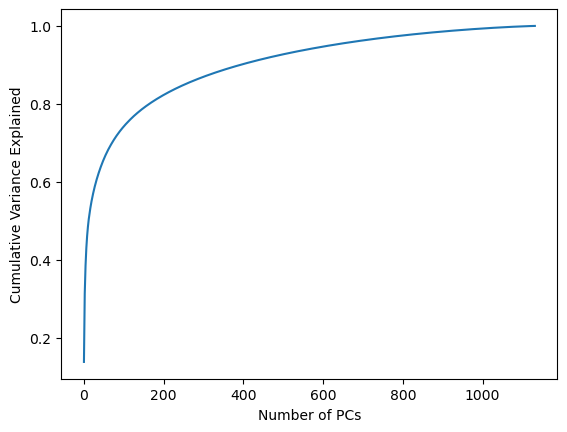

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of PCs")
plt.ylabel("Cumulative Variance Explained")

num_pcs_99 = np.argmax(np.cumsum(pca.explained_variance_ratio_) >= 0.99) + 1
print(f"Number of PCs required to retain 99% variance: {num_pcs_99}")


In [52]:
# drop people after they are clustered if they don't have labels
for n_pcs in [2,3,4,5,10,15,20,25,50,100,200]:
    X_pca = PCA(n_components=n_pcs).fit_transform(df_pca_scaled.iloc[:,2:])
    cluster_labels = KMeans(n_clusters=5).fit_predict(X_pca)
    labeled_idx = pam50_labels.dropna().index
    ari = adjusted_rand_score(pam50_labels[labeled_idx], cluster_labels[labeled_idx])
    print(f"{n_pcs} PCs → ARI: {ari:.3f}")

2 PCs → ARI: 0.129
3 PCs → ARI: 0.254
4 PCs → ARI: 0.223
5 PCs → ARI: 0.222
10 PCs → ARI: 0.240
15 PCs → ARI: 0.242
20 PCs → ARI: 0.251
25 PCs → ARI: 0.250
50 PCs → ARI: 0.244
100 PCs → ARI: 0.247
200 PCs → ARI: 0.247


In [50]:
# drop people before they are clustered if they dont' have labels
df_pca_scaled_labeled = df_pca_scaled.loc[pam50_labels.dropna().index]
for n_pcs in [2,3,4,5,10,15,20,25,50,100,200]:
    X_pca = PCA(n_components=n_pcs).fit_transform(df_pca_scaled_labeled.iloc[:,2:])
    cluster_labels = KMeans(n_clusters=5).fit_predict(X_pca)
    ari = adjusted_rand_score(pam50_labels.dropna(), cluster_labels)
    print(f"{n_pcs} PCs → ARI: {ari:.3f}")


2 PCs → ARI: 0.246
3 PCs → ARI: 0.223
4 PCs → ARI: 0.206
5 PCs → ARI: 0.210
10 PCs → ARI: 0.224
15 PCs → ARI: 0.230
20 PCs → ARI: 0.225
25 PCs → ARI: 0.229
50 PCs → ARI: 0.241
100 PCs → ARI: 0.207
200 PCs → ARI: 0.221


In [60]:
# drop people after pca but before clustering
for n_pcs in [2,3,4,5,10,15,20,25,50,100,200]:
    X_pca = PCA(n_components=n_pcs).fit_transform(df_pca_scaled.iloc[:,2:])
    X_pca = X_pca[~pam50_labels.isna()]
    cluster_labels = KMeans(n_clusters=5).fit_predict(X_pca)
    ari = adjusted_rand_score(pam50_labels.dropna(), cluster_labels)
    print(f"{n_pcs} PCs → ARI: {ari:.3f}")

2 PCs → ARI: 0.134
3 PCs → ARI: 0.230
4 PCs → ARI: 0.205
5 PCs → ARI: 0.211
10 PCs → ARI: 0.212
15 PCs → ARI: 0.228
20 PCs → ARI: 0.222
25 PCs → ARI: 0.230
50 PCs → ARI: 0.229
100 PCs → ARI: 0.237
200 PCs → ARI: 0.218


In [78]:
for n_pcs in [50]:
    X_pca = PCA(n_components=n_pcs).fit_transform(df_pca_scaled.iloc[:,2:])
    cluster_labels = KMeans(n_clusters=5).fit_predict(X_pca)
    labeled_idx = pam50_labels.dropna().index
    ari = adjusted_rand_score(pam50_labels[labeled_idx], cluster_labels[labeled_idx])
    print(f"{n_pcs} PCs → ARI: {ari:.3f}")

X_pca

50 PCs → ARI: 0.246


array([[-19.27001642, -40.54655597,  18.18768846, ...,  16.46847899,
         -2.31274798,  -0.84314788],
       [-54.96652734,   6.74939038,   9.38892729, ...,  -2.09987592,
          2.80235537,  15.9700991 ],
       [-59.33018958,  10.49591516,  18.28012617, ...,   7.4319041 ,
         -4.59694262,   0.52502942],
       ...,
       [ 12.28927082,  44.13561271,  29.44270333, ...,  12.15408411,
          0.08792272,  -2.549831  ],
       [-70.20080391,  65.02689127,  57.23162125, ...,   0.13725817,
         -0.85317981,   0.13474014],
       [-63.37889411, -23.29887858,  12.97274069, ...,   5.32231542,
         -0.12225964,  -9.00051842]], shape=(1132, 50))

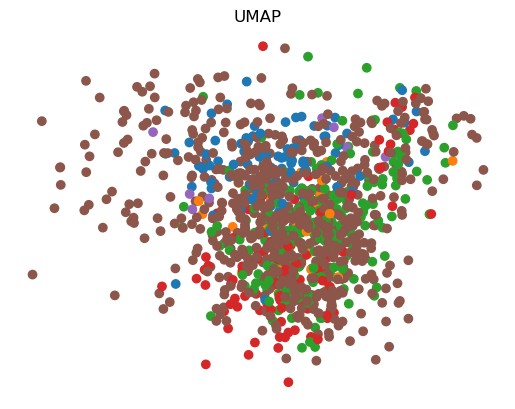

In [79]:
plot_embedding(X_pca)

/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.6861891746520996 s


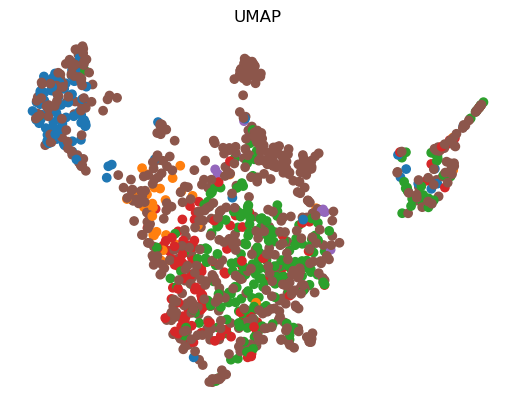

In [80]:
umap_embedding = umap_reduce(X_pca)
plot_embedding(umap_embedding)

In [84]:
# drop people after they are clustered if they don't have labels
for n_pcs in [2,3,4,5,10,15,20,25,50,100,200]:
    X_pca = PCA(n_components=n_pcs).fit_transform(df_pca_scaled.iloc[:,2:])
    X_umap = umap_reduce(X_pca)
    #X_mds = mds_reduce(X_pca)
    #X_tsne = tsne_reduce(X_pca)
    for data in [X_pca, X_umap]:
        cluster_labels = KMeans(n_clusters=5).fit_predict(data)
        labeled_idx = pam50_labels.dropna().index
        ari = adjusted_rand_score(pam50_labels[labeled_idx], cluster_labels[labeled_idx])
        print(f"{n_pcs} PCs → ARI: {ari:.3f}")

/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.8119935989379883 s
2 PCs → ARI: 0.129
2 PCs → ARI: 0.114


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.441990375518799 s
3 PCs → ARI: 0.251
3 PCs → ARI: 0.238


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.7911036014556885 s
4 PCs → ARI: 0.224
4 PCs → ARI: 0.222


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.3957152366638184 s
5 PCs → ARI: 0.225
5 PCs → ARI: 0.219


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.136410713195801 s
10 PCs → ARI: 0.238
10 PCs → ARI: 0.246


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.353571891784668 s
15 PCs → ARI: 0.242
15 PCs → ARI: 0.270


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 4.299942255020142 s
20 PCs → ARI: 0.233
20 PCs → ARI: 0.288


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.364286184310913 s
25 PCs → ARI: 0.250
25 PCs → ARI: 0.271


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.4623661041259766 s
50 PCs → ARI: 0.240
50 PCs → ARI: 0.248


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.4962050914764404 s
100 PCs → ARI: 0.240
100 PCs → ARI: 0.207


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 3.8468620777130127 s
200 PCs → ARI: 0.245
200 PCs → ARI: 0.191


In [ ]:
pam50_labels['Normal-like']

In [96]:
pam50_labels.unique()

array([nan, 'Luminal A', 'Luminal B', 'Basal-like', 'HER2-enriched',
       'Normal-like'], dtype=object)

In [91]:
# drop people after they are clustered if they don't have labels
for n_pcs in [2,3,4,5,10,15,20,25,50]:
    scaler = StandardScaler()
    scaled = scaler.fit_transform(df_umap.iloc[:, 2:])
    X_pca = PCA(n_components=n_pcs).fit_transform(scaled)
    X_umap = umap_reduce(X_pca)
    #X_mds = mds_reduce(X_pca)
    #X_tsne = tsne_reduce(X_pca)
    for data in [X_pca, X_umap]:
        cluster_labels = KMeans(n_clusters=5).fit_predict(data)
        labeled_idx = pam50_labels.dropna().index
        ari = adjusted_rand_score(pam50_labels[labeled_idx], cluster_labels[labeled_idx])
        print(f"{n_pcs} PCs → ARI: {ari:.3f}")

/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.9016895294189453 s
2 PCs → ARI: 0.224
2 PCs → ARI: 0.217


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.5526044368743896 s
3 PCs → ARI: 0.238
3 PCs → ARI: 0.237


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.658883571624756 s
4 PCs → ARI: 0.277
4 PCs → ARI: 0.211


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.222825765609741 s
5 PCs → ARI: 0.290
5 PCs → ARI: 0.249


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.237321376800537 s
10 PCs → ARI: 0.303
10 PCs → ARI: 0.256


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.3740639686584473 s
15 PCs → ARI: 0.301
15 PCs → ARI: 0.267


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.4970219135284424 s
20 PCs → ARI: 0.306
20 PCs → ARI: 0.278


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.183159112930298 s
25 PCs → ARI: 0.301
25 PCs → ARI: 0.282


/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/chris/miniconda3/envs/brca-clustering/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP running time is: 2.4082748889923096 s
50 PCs → ARI: 0.303
50 PCs → ARI: 0.269


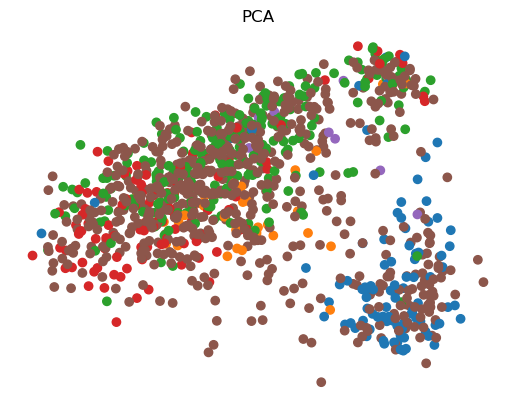

In [93]:
plot_embedding(X_pca, title='PCA')

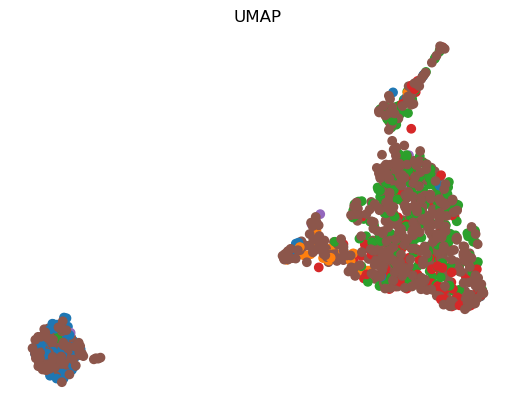

In [94]:
plot_embedding(X_umap, title='UMAP')

,patient_id,sample_id,?|100133144,?|100134869,?|10357,?|10431,?|155060,?|390284,?|57714,?|645851,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01A-11R-A41B-07,4.118061,3.800289,5.732006,8.676225,10.214331,2.360617,9.682954,6.970647,...,8.703295,9.865667,7.028923,9.978396,10.696533,8.019557,10.240040,11.776536,10.888690,10.206355
1,TCGA-3C-AALI,TCGA-3C-AALI-01A-11R-A41B-07,3.359788,4.199986,6.144766,9.141834,9.014135,1.395776,9.470734,7.164595,...,10.182804,9.916175,5.926358,8.812540,10.392446,7.640079,9.239811,12.426689,10.365940,8.671516
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01A-31R-A41B-07,3.657960,3.354650,7.278886,10.411331,9.211942,1.895264,8.617133,5.147775,...,8.259376,11.306221,5.184205,9.063390,9.588362,8.378607,9.058492,12.414619,9.882464,8.995821
3,TCGA-3C-AALK,TCGA-3C-AALK-01A-11R-A41B-07,3.710327,3.594537,7.178555,9.759116,9.113094,2.472774,8.842369,4.063676,...,8.627556,9.387149,5.808048,8.777199,9.756358,7.462903,9.248793,12.474809,9.611272,9.455058
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01A-12R-A41B-07,2.972104,3.947647,6.412998,9.583803,8.032602,1.992297,8.814941,3.951224,...,8.667860,9.399744,5.642014,8.732184,10.037259,3.910982,9.601297,11.981103,9.702025,9.785783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,TCGA-WT-AB44,TCGA-WT-AB44-01A-11R-A41B-07,0.000000,2.090176,5.435105,10.875304,9.462586,2.342697,8.293550,3.058403,...,7.238538,7.506359,4.668738,7.933897,9.596113,6.637412,8.304744,13.417075,9.646832,8.794699
1128,TCGA-XX-A899,TCGA-XX-A899-01A-11R-A36F-07,3.943528,4.488059,7.116614,9.352608,8.742023,2.943528,9.369021,4.370513,...,8.836199,8.839478,6.167239,9.332486,10.307816,4.476369,9.428756,12.321677,10.918013,9.390339
1129,TCGA-XX-A89A,TCGA-XX-A89A-01A-11R-A36F-07,4.543743,4.821425,6.025532,9.499290,8.560241,2.928484,8.543902,3.679108,...,9.053106,9.441656,5.633832,8.420049,10.426820,7.369676,9.546532,12.419581,10.490259,9.898916
1130,TCGA-Z7-A8R5,TCGA-Z7-A8R5-01A-42R-A41B-07,1.706553,3.051946,6.427038,10.156437,7.983381,2.373286,6.861484,1.760987,...,7.443847,8.020363,5.055508,7.962803,9.638843,5.727014,8.985637,12.704904,9.561122,9.554261


<h1>UMAP/t-SNE</h1>

<h2>UMAP/t-SNE Preprocessing</h2>

In [ ]:
# prune collinear genes
corr_matrix = df_highvar.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop genes with any highly correlated partner
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_uncorrelated = df_highvar.drop(columns=to_drop)


In [111]:
pam50_df = pd.read_csv('/home/chris/code/ucsd/beng285/breast-cancer-team-1/data/pam50.tsv', sep='\t')
pam50 = [f"{row['GeneName']}|{row['EntrezGene']}" for _, row in pam50_df.iterrows()]
pam50


['ACTR3B|57180',
 'ANLN|54443',
 'BAG1|573',
 'BCL2|596',
 'BIRC5|332',
 'BLVRA|644',
 'CCNB1|891',
 'CCNE1|898',
 'CDC20|991',
 'CDC6|990',
 'NUF2|83540',
 'CDH3|1001',
 'CENPF|1063',
 'CEP55|55165',
 'CXXC5|51523',
 'EGFR|1956',
 'ERBB2|2064',
 'ESR1|2099',
 'EXO1|9156',
 'FGFR4|2264',
 'FOXA1|3169',
 'FOXC1|2296',
 'GPR160|26996',
 'GRB7|2886',
 'KIF2C|11004',
 'NDC80|10403',
 'KRT14|3861',
 'KRT17|3872',
 'KRT5|3852',
 'MAPT|4137',
 'MDM2|4193',
 'MELK|9833',
 'MIA|8190',
 'MKI67|4288',
 'MLPH|79083',
 'MMP11|4320',
 'MYBL2|4605',
 'MYC|4609',
 'NAT1|9',
 'ORC6L|23594',
 'PGR|5241',
 'PHGDH|26227',
 'PTTG1|9232',
 'RRM2|6241',
 'SFRP1|6422',
 'SLC39A6|25800',
 'TMEM45B|120224',
 'TYMS|7298',
 'UBE2C|11065',
 'UBE2T|29089']

In [ ]:
zaid50 = "LOC84740|84740, FOXD1|2297, PCSK1|5122, COL11A2|1302, FAM196A|642938, PFKFB1|5207, CABP7|164633, MKX|283078, TTYH1|57348, GABRB3|2562, ATP1A3|478, CITED1|4435, CYP4F22|126410, PDE1C|5137, DLGAP3|58512, ARC|23237, MAST1|22983, NPC1L1|29881, JPH3|57338, CALML5|51806, PPP1R14C|81706, HCN2|610, HRCT1|646962, RNF182|221687, IGFALS|3483, ABCC2|1244, GRPR|2925, TEX14|56155, SOX8|30812, C2orf50|130813, PSCA|8000, LOC84856|84856, PTX3|5806, MGAT5B|146664, VIT|5212, RGN|9104, FAM178B|51252, C2CD4B|388125, MYEOV|26579, CHRNB2|1141, EPHX3|79852, SHC4|399694, ANKRD45|339416, SMOC1|64093, POMC|5443, NMUR1|10316, THPO|7066, ATP8A2|51761, SPESP1|246777, NRTN|4902".split(", ")
zaid50

['LOC84740|84740',
 'FOXD1|2297',
 'PCSK1|5122',
 'COL11A2|1302',
 'FAM196A|642938',
 'PFKFB1|5207',
 'CABP7|164633',
 'MKX|283078',
 'TTYH1|57348',
 'GABRB3|2562',
 'ATP1A3|478',
 'CITED1|4435',
 'CYP4F22|126410',
 'PDE1C|5137',
 'DLGAP3|58512',
 'ARC|23237',
 'MAST1|22983',
 'NPC1L1|29881',
 'JPH3|57338',
 'CALML5|51806',
 'PPP1R14C|81706',
 'HCN2|610',
 'HRCT1|646962',
 'RNF182|221687',
 'IGFALS|3483',
 'ABCC2|1244',
 'GRPR|2925',
 'TEX14|56155',
 'SOX8|30812',
 'C2orf50|130813',
 'PSCA|8000',
 'LOC84856|84856',
 'PTX3|5806',
 'MGAT5B|146664',
 'VIT|5212',
 'RGN|9104',
 'FAM178B|51252',
 'C2CD4B|388125',
 'MYEOV|26579',
 'CHRNB2|1141',
 'EPHX3|79852',
 'SHC4|399694',
 'ANKRD45|339416',
 'SMOC1|64093',
 'POMC|5443',
 'NMUR1|10316',
 'THPO|7066',
 'ATP8A2|51761',
 'SPESP1|246777',
 'NRTN|4902']

In [ ]:
X_zaid50 = df_logexp_filtered.loc[:,zaid50]
X_pam50 = df_logexp_filtered.loc[:,pam50]

(1132, 50)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity([A_mean], [B_mean])[0, 0]
